In [1]:
from utils import CIFAR10Data, plot_costs_accuracies
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt

## Two Layer Classifier

In [2]:
class TwoLayerClassifer:
    def __init__(self, input_dim, n_hidden, batch_size=100, eta=0.001, n_epochs=20, lamda=0, cyclical_lr=False, n_s=None, eta_min=None, eta_max=None, lr_range_test=False, dropout_thresh=None):
        n_classes = 10
        self.batch_size = batch_size # number of images in a batch
        self.n_epochs = n_epochs
        self.lamda = lamda
        self.cyclical_lr = cyclical_lr
        if cyclical_lr:
            self.batch_size = 100
            self.l = 0
            self.n_s = n_s # step size
            self.eta_min = eta_min
            self.eta_max = eta_max
            self.plot_every_n_steps = int(2*n_s/10)
        else:
            self.eta = eta
        self.lr_range_test = lr_range_test # whether to perform learning rate range test to see what eta_min and eta_max should be
        self.plot_every_n_steps = batch_size 
        self.n_hidden = n_hidden
        self.dropout_thresh = dropout_thresh # proportion of nodes to switch off ( =(1-p) from slides)
        
        # initialise weight matrix and bias
        self.W1 = np.random.normal(loc=0, scale=1/np.sqrt(input_dim), size=(n_hidden, input_dim))  # m x d
        self.W2 = np.random.normal(loc=0, scale=1/np.sqrt(n_hidden), size=(n_classes, n_hidden)) # K x m
        self.b1 = np.zeros((n_hidden,1))
        self.b2 = np.zeros((n_classes,1))
        
        

    def normalise(self, train_X, val_X, test_X):
        ''' X has shape (d,n) where d = dimensionality of each image, n is number of images '''
        mean = np.mean(train_X, axis=1)
        std = np.std(train_X, axis=1)
        original_shape = train_X.shape
        # apply same transformation to all of the datasets using params from train set
        def _normalise_helper(a, m, s):
            return ((a.T - m.T) / s.T).T
        
        train_X = _normalise_helper(train_X, mean, std)
        val_X = _normalise_helper(val_X, mean, std)
        test_X = _normalise_helper(test_X, mean, std)
        return train_X, val_X, test_X

    
    def forward_pass(self, X, W1, W2, b1, b2, dropout_thresh=None):
        S1 = np.dot(W1, X) + b1
        H = np.where(S1 >= 0, S1, 0) # apply RELU activation
        
        indices = np.ones(H.shape[0])

        if dropout_thresh is not None:
#             u1_batch = np.random.binomial(1,1-dropout_thresh,H.shape)
            curr_indices = np.copy(indices)
            dropout_thresh = 0.2
            number_to_zero = H.shape[0]*dropout_thresh
            curr_indices[-int(number_to_zero):] = 0
            u1_batch = np.asarray([np.random.permutation(curr_indices) for i in range(H.shape[1])]).T
            ''' divide by p = 1-dropout_thresh = proportion of connections to keep 
                so that don't have to compensate at test'''
            u1_batch /= (1-dropout_thresh) 
            H = np.multiply(H, u1_batch)
        S = np.dot(W2,H) + b2
        
        P = self.softmax(S) # probabiliites, apply softmax to every column
        return H, P
    

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)


    def compute_accuracy(self, X, Y):
        ''' X is data (dim, N), y is gt (C, N), W is weight matrix, b is bias, Y is 1hot encoded labels'''
        _, P = self.forward_pass(X, self.W1, self.W2, self.b1, self.b2)
        pred = np.argmax(P, axis=0)
        lbls = np.argmax(Y, axis=0)
        accuracy = np.mean(pred == lbls)
        return pred, accuracy
    

    def compute_cost(self, X, Y, W1, W2, b1, b2):
        ''' 
            X: dxn (dimensionality by # images)
            Y: Kxn (no. classes one-hot encoded by # images)
            J: scalar corresponding to sum of loss of ntwks predictions of X relative to gt labels 
        '''
        _, P = self.forward_pass(X, W1, W2, b1, b2)
        N = X.shape[1]
        #  loss function + regularisation term
#             loss = -np.trace(Y*np.log(P)) / N
        loss = -np.sum(Y*np.log(P)) / N
        cost = loss + self.lamda * (np.sum(W1**2) + np.sum(W2**2))
    
        return loss, cost
        
    
    
    def compute_gradients(self, X, Y, W1, W2, b1, b2):
        ''' computes gradients of the cost function wrt W and b for batch X '''
        N = X.shape[1]

        # forward pass, apply dropout if its set
        H, P = self.forward_pass(X, W1, W2, b1, b2, self.dropout_thresh)
        
        # backward pass
        G = -(Y - P)
       
        grad_W2 =  np.dot(G, H.T) / N + 2 * self.lamda * W2 
        grad_b2 =  np.sum(G, axis=1) / N
        
        grad_b2 = grad_b2.reshape((grad_b2.shape[0],1))

        # propagate gradient back through second layer
        G = np.dot(W2.T, G)
        Ind = H > 0
        G = np.multiply(G, Ind)
        grad_W1 =  np.dot(G, X.T) / N + self.lamda * W1 # 2 or 1 * lamda * W?
        grad_b1 =  np.sum(G, axis=1) / N
        grad_b1 = grad_b1.reshape((grad_b1.shape[0],1))
        
        return grad_W1, grad_W2, grad_b1, grad_b2
    
   
    def compute_cyclical_lr(self, t):
        l = self.l
        eta_min = self.eta_min
        eta_max = self.eta_max
        n_s = self.n_s
        if t >= 2*l*n_s and t <= (2*l+1)*n_s:
            eta = eta_min + (t-2*l*n_s)*(eta_max-eta_min)/n_s
        elif t >= (2*l+1)*n_s and t <= 2*(l+1)*n_s:
            eta = eta_max - (t - (2*l+1)*n_s)*(eta_max-eta_min)/n_s
            
        if t % (2*n_s) == 0 and t > 0: # update l every 2*n_s steps
                self.l += 1
        return eta
    
        
        
    def train(self, X, Y, random_shuffle=False, val_X=None, val_Y=None, get_accuracies_costs=False, max_lr=0.1):
        n = X.shape[1]
        
        number_of_batches = int(n / self.batch_size)
        assert number_of_batches > 0
        indices = np.arange(X.shape[1])
        if random_shuffle:
            print('Randomly shuffling')
        
        if self.cyclical_lr:
            print('Cyclical learning rate')
       
        accuracies = {'train': [], 'val': []}
        costs = {'train': [], 'val': []}
        losses = {'train': [], 'val': []}
        update_steps = []
        
        eta = self.eta if not self.cyclical_lr else None
        t = 0 # each update step % 2*n_s
        if self.lr_range_test:
            eta = 0
            
            self.plot_every_n_step = int(self.n_epochs * number_of_batches / 20)
            eta_incr = max_lr * self.plot_every_n_step / (self.n_epochs * number_of_batches)
            
        
        for epoch in range(self.n_epochs):     
            if random_shuffle:
                np.random.shuffle(indices)
                X = np.take(X, indices, axis=1)
                Y = np.take(Y, indices, axis=1)
                
            for j in range(number_of_batches):
                if self.cyclical_lr:
                    eta = self.compute_cyclical_lr(t)
                
                
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
                
                # Perform MiniBatch Gradient Descent
                grad_W1, grad_W2, grad_b1, grad_b2 = self.compute_gradients(Xbatch, Ybatch, self.W1, self.W2, self.b1, self.b2)
                self.W1 -= eta * grad_W1
                self.W2 -= eta * grad_W2
                self.b1 -= eta *  grad_b1
                self.b2 -= eta *  grad_b2

                if get_accuracies_costs and (t % self.plot_every_n_steps == 0):
                    _, train_accuracy = self.compute_accuracy(X, Y)
                    _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                    accuracies['train'].append(train_accuracy)
                    accuracies['val'].append(val_accuracy)
                    train_loss, train_cost = self.compute_cost(X, Y, self.W1, self.W2, self.b1, self.b2)
                    val_loss, val_cost = self.compute_cost(val_X, val_Y, self.W1, self.W2, self.b1, self.b2)
                    costs['train'].append(train_cost)
                    costs['val'].append(val_cost)
                    losses['train'].append(train_loss)
                    losses['val'].append(val_loss)
                    update_steps.append(t)
            
                
                if self.lr_range_test and (t % self.plot_every_n_step == 0):
                    update_steps.append(eta)
                    _, train_accuracy = self.compute_accuracy(X, Y)
                    _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                    accuracies['train'].append(train_accuracy)
                    accuracies['val'].append(val_accuracy)
                    eta += eta_incr
                    
                t += 1
   

        return accuracies, losses, costs, update_steps
 

In [3]:
# load in data and normalise
CIFARDATA = CIFAR10Data(dataset_dir='../datasets/cifar-10-batches-py/')
train_X, train_Y = CIFARDATA.load_batch('data_batch_1')
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

Let's check gradients are correct for 2 layer classifier

In [4]:
def compute_grads_num(clf, X, Y, W1, W2, b1, b2, lamda=0, h=1e-5):
#     N = W.shape[0]
    D = X.shape[0]

    grad_W1 = np.zeros(W1.shape)
    grad_W2 = np.zeros(W2.shape)
    grad_b1 = np.zeros((W1.shape[0], 1))
    grad_b2 = np.zeros((W2.shape[0], 1))

    c = clf.compute_cost(X, Y, W1, W2, b1, b2)

    for i in range(len(b1)):
        b_try = np.array(b1)
        b_try[i] += h
        c2 = clf.compute_cost(X, Y, W1, W2, b_try, b2)
        grad_b1[i] = (c2-c) / h
    
    for i in range(len(b2)):
        b_try = np.array(b2)
        b_try[i] += h
        c2 = clf.compute_cost(X, Y, W1, W2, b1, b_try)
        grad_b1[i] = (c2-c) / h

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W_try = np.array(W1)
            W_try[i,j] += h

            c2 = clf.compute_cost(X, Y, W_try, W2, b1, b2)
            grad_W1[i,j] = (c2-c) / h
            
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W_try = np.array(W2)
            W_try[i,j] += h

            c2 = clf.compute_cost(X, Y, W1, W_try, b1, b2)
            grad_W2[i,j] = (c2-c) / h

    return grad_W1, grad_W2, grad_b1, grad_b2
    
    
def check_gradients_are_equal(clf, X_train, Y_train_1hot, num_samples=20, weight_subset=None):
    # choose random subset of num_samples to test on
    indices = np.arange(X_train.shape[1])
    np.random.shuffle(indices)
    indices = indices[:num_samples]
  
    X_a = np.take(X_train, indices, axis=1)
    Y_a = np.take(Y_train_1hot, indices, axis=1)
    X_n = np.copy(X_a)
    Y_n = np.copy(Y_a)
    
    # take subset of weight matrices to speed up computation
    if weight_subset is not None:
        clf.W1 = clf.W1[:weight_subset,:]
#         clf.W2 = clf.W2[:weight_subset,:]
   
    W1_copy = np.copy(clf.W1)
    b1_copy = np.copy(clf.b1)
    W2_copy = np.copy(clf.W2)
    b2_copy = np.copy(clf.b2)
    
    grad_W1_ana, grad_W2_ana, grad_b1_ana, grad_b2_ana = clf.compute_gradients(X_a, Y_a, clf.W1, clf.W2, clf.b1, clf.b2)
    
    # reset params
    clf.W1 = np.copy(W1_copy)
    clf.W2 = np.copy(W2_copy)
    clf.b1 = np.copy(b1_copy)
    clf.b2 = np.copy(b2_copy)
    grad_W1_num, grad_W2_num, grad_b1_num, grad_b2_num = compute_grads_num(clf, X_n, Y_n, clf.W1, clf.W2, clf.b1, clf.b2, clf.lamda)
    
    def compare_gradients(g_n, g_a, eps=0.000001):
        err = np.linalg.norm(g_a-g_n) / max(eps, np.linalg.norm(g_a) + np.linalg.norm(g_n))
        print('relative error', err)
        print('err < 10**-6', err < 10**-6)
        return err

    # check whether they're similar
    compare_gradients(grad_W1_num, grad_W1_ana)
    compare_gradients(grad_W2_num, grad_W2_ana)

In [32]:
# compare gradients
n_classes = 10
input_dim = train_X.shape[0]
clf = TwoLayerClassifer(input_dim, n_hidden=10, batch_size=20, cyclical_lr=False)
check_gradients_are_equal(clf, train_X, train_Y)

relative error 1.9865405009811453e-06
err < 10**-6 False
relative error 3.0304071252119502e-06
err < 10**-6 False


Let's now check we can overfit on the dataset.

train accuracy 0.81
test accuracy 0.1791


/Users/amritapanesar/KTH-Courses/Artificial-Neural-Networks/venv-anns/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


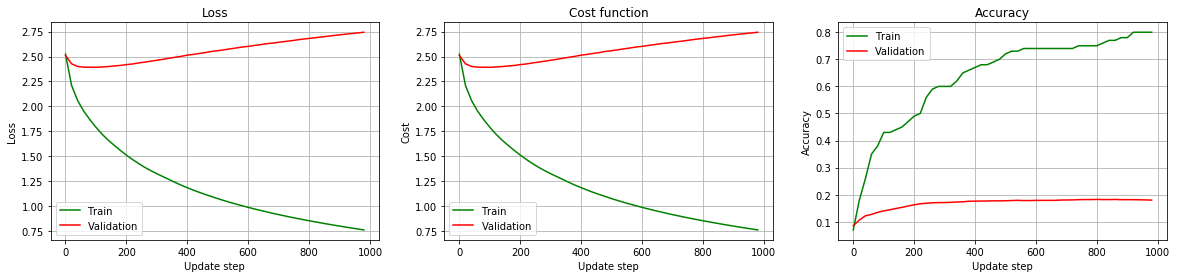

In [5]:
input_dim = train_X.shape[0]
clf = TwoLayerClassifer(input_dim, n_hidden=10, batch_size=20, n_epochs=200, cyclical_lr=False)
train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
X = train_X[:,:100]
Y = train_Y[:,:100]
accuracies, losses, costs, update_steps = clf.train(X, Y, val_X=val_X, val_Y=val_Y, get_accuracies_costs=True)
_, test_accuracy = clf.compute_accuracy(test_X, test_Y) # use lables to compute accuracy
_, train_accuracy = clf.compute_accuracy(X, Y)
print('train accuracy', train_accuracy)
print('test accuracy', test_accuracy)
plot_costs_accuracies(accuracies, losses, costs, update_steps)

Seems as if we are, which is good as its expected with such a small training set.

### Compute Cyclical learning rates and check these are correct

Let us write the function to compute the cyclical learning rate and plot this over time to check that the update rule is correct.

min y 9.999999999996123e-06


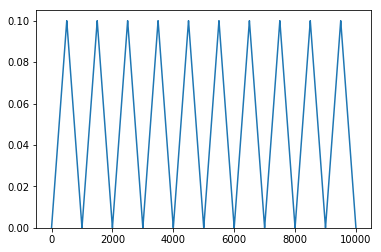

In [186]:
def plot_lr():
    eta_min = 1*10**-5
    eta_max = 0.1
    n_s = 500
    n_epochs=10000
    
    x = []
    y = []
    
    l = 0
    for epoch in range(n_epochs):
        if epoch >= 2*l*n_s and epoch <= (2*l+1)*n_s:
            eta = eta_min + (epoch-2*l*n_s)*(eta_max-eta_min)/n_s
        elif epoch >= (2*l+1)*n_s and epoch <= 2*(l+1)*n_s:
            eta = eta_max - (epoch - (2*l+1)*n_s)*(eta_max-eta_min)/n_s

        if epoch % (2*n_s) == 0 and epoch > 0:
            l += 1
        x.append(epoch)
        y.append(eta)
    print('min y', min(y))
    plt.plot(x,y)
    plt.ylim(min(y))
    plt.show()
plot_lr()

Seems about right.

### Train network with cyclical learning rates 

In [4]:
def train_model(params, datasets, plot_acc_costs=False):
    train_X, train_Y, val_X, val_Y, test_X , test_Y = datasets
    n_classes = 10
    input_dim = train_X.shape[0]
    random_shuffle = params['random_shuffle'] if 'random_shuffle' in params else False
#     eta = params['eta'] if 'eta' in params else None
    dropout_thresh = params['dropout_thresh'] if 'droput_thresh' in params else None

    if 'eta' in params:
        clf = TwoLayerClassifer(input_dim, params['n_hidden'], params['batch_size'], eta=params['eta'], n_epochs=params['n_epochs'], lamda=params['lamda'], cyclical_lr=False)
    else:
        clf = TwoLayerClassifer(input_dim, params['n_hidden'], params['batch_size'], n_epochs=params['n_epochs'], lamda=params['lamda'], cyclical_lr=True, n_s=params['n_s'], eta_min=params['eta_min'], eta_max=params['eta_max'], dropout_thresh=dropout_thresh)
        
    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
    accuracies, losses, costs, update_steps = clf.train(train_X, train_Y, random_shuffle, get_accuracies_costs=plot_acc_costs, 
                                  val_X = val_X, val_Y = val_Y)
    if plot_acc_costs:
        plot_costs_accuracies(accuracies, losses, costs, update_steps)


    _, test_accuracy = clf.compute_accuracy(test_X, test_Y) # use lables to compute accuracy
    _, val_accuracy = clf.compute_accuracy(val_X, val_Y)
    print('test_accuracy', test_accuracy)
    return {'test_accuracy': test_accuracy, 'val_accuracy': val_accuracy}

First we train for 1 cycle, where each cycle has 1000 steps (batch size=100, run for 10 epochs = 100*10 =1000 steps).

Cyclical learning rate


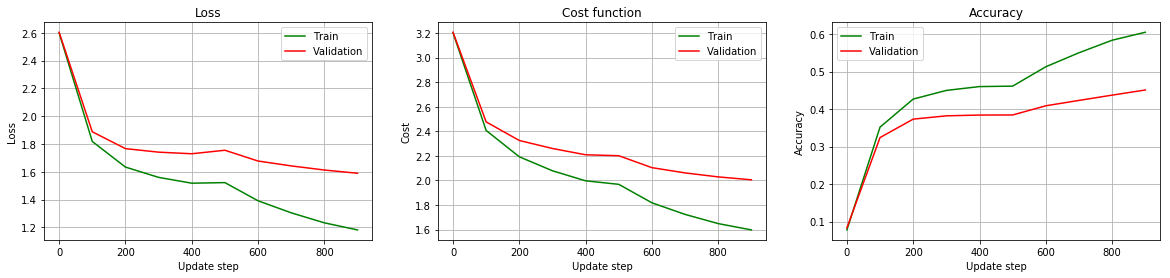

test_accuracy 0.457


{'test_accuracy': 0.457, 'val_accuracy': 0.4586}

In [7]:
# 10 epochs, batch size 100 = 1000 update steps
params = {'lamda': 0.01, 'n_epochs':  10, 'batch_size': 100, 'n_hidden': 50,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 500}
         
train_model(params, datasets, plot_acc_costs=True)

### Train network for longer 

Now let us train for 3 cycles, with 1600 steps per cycle. 3*800*2 / 100

Cyclical learning rate


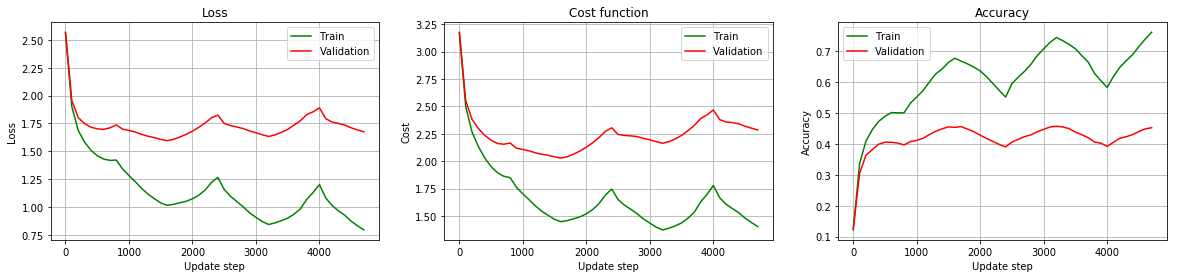

test_accuracy 0.4547


{'test_accuracy': 0.4547, 'val_accuracy': 0.4567}

In [9]:
params = {'lamda': 0.01, 'n_epochs':  48, 'batch_size': 100, 'n_hidden': 50,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 800}
         
train_model(params, datasets, plot_acc_costs=True)

### Coarse to random search for Regularisation term lamda

We use all of the training data that we would use in the final model to find the optimal value of lamda since adding more training data acts as regularisation and would mean the optimal lamda found with less training data
would no longer be valid.

In [10]:
train_X, train_Y = CIFARDATA.load_batches(['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4'])
val_X, val_Y = CIFARDATA.load_batch('data_batch_5')
train_X = np.hstack((train_X, val_X[:,:5000]))
train_Y = np.hstack((train_Y, val_Y[:,:5000]))
val_X = val_X[:,5000:]
val_Y = val_Y[:,5000:]
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

In [50]:
# coarse search for 2 cycles 
test_results = []
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 2*int(number_of_batches)
no_cycles = 2
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l = -5
while l <= -1:
    print(l)
    params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 50,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': 10**l, 'l': l}
    res = train_model(params, datasets, plot_acc_costs=False)
    test_results.append({**params, **res})
    l += 0.5


-5
Cyclical learning rate
test_accuracy 0.508
-4.5
Cyclical learning rate
test_accuracy 0.507
-4.0
Cyclical learning rate
test_accuracy 0.5075
-3.5
Cyclical learning rate
test_accuracy 0.5114
-3.0
Cyclical learning rate
test_accuracy 0.5098
-2.5
Cyclical learning rate
test_accuracy 0.5137
-2.0
Cyclical learning rate
test_accuracy 0.5129
-1.5
Cyclical learning rate
test_accuracy 0.4885
-1.0
Cyclical learning rate
test_accuracy 0.4185


In [51]:
import pandas as pd

df_coarse_search = pd.DataFrame(test_results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
print(df_coarse_search[['lamda', 'l', 'val_accuracy', 'test_accuracy']])
df_coarse_search.to_csv('coarse_search.csv')

      lamda    l  val_accuracy  test_accuracy
5  0.003162 -2.5        0.5246         0.5137
6  0.010000 -2.0        0.5170         0.5129
3  0.000316 -3.5        0.5166         0.5114
4  0.001000 -3.0        0.5228         0.5098
0  0.000010 -5.0        0.5078         0.5080
2  0.000100 -4.0        0.5150         0.5075
1  0.000032 -4.5        0.5196         0.5070
7  0.031623 -1.5        0.4896         0.4885
8  0.100000 -1.0        0.4132         0.4185


In [192]:
df_coarse_search[['lamda', 'l', 'val_accuracy', 'test_accuracy']]

,lamda,l,val_accuracy,test_accuracy
5,0.003162,-2.5,0.5246,0.5137
6,0.010000,-2.0,0.5170,0.5129
3,0.000316,-3.5,0.5166,0.5114
4,0.001000,-3.0,0.5228,0.5098
0,0.000010,-5.0,0.5078,0.5080
2,0.000100,-4.0,0.5150,0.5075
1,0.000032,-4.5,0.5196,0.5070
7,0.031623,-1.5,0.4896,0.4885
8,0.100000,-1.0,0.4132,0.4185


In [190]:
# random search, running in refined interval for more cycles (4)
import random

results = []

batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 4*int(number_of_batches)
no_cycles = 4
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l_min = -2.5
l_max = -2

for x in range(10):
    l = l_min + (l_max - l_min)*random.uniform(0, 1)
    params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 50,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': 10**l, 'l': l}
    res = train_model(params, datasets, plot_acc_costs=False)
    results.append({**params, **res})

Cyclical learning rate
test_accuracy 0.524
Cyclical learning rate
test_accuracy 0.5271
Cyclical learning rate
test_accuracy 0.5249
Cyclical learning rate
test_accuracy 0.5222
Cyclical learning rate
test_accuracy 0.5233
Cyclical learning rate
test_accuracy 0.5225
Cyclical learning rate
test_accuracy 0.5172
Cyclical learning rate
test_accuracy 0.5228
Cyclical learning rate
test_accuracy 0.5228
Cyclical learning rate
test_accuracy 0.5268


In [194]:
# df_random_search = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_random = pd.read_csv('random_search.csv')
df_random[['lamda', 'l', 'val_accuracy', 'test_accuracy']]
# df_random_search.to_csv('random_search.csv')

,lamda,l,val_accuracy,test_accuracy
0,0.009139,-2.039120,0.5382,0.5280
1,0.007070,-2.150608,0.5246,0.5276
2,0.007054,-2.151575,0.5380,0.5272
3,0.005079,-2.294234,0.5308,0.5269
4,0.008190,-2.086725,0.5306,0.5254
5,0.009401,-2.026821,0.5336,0.5249
6,0.009422,-2.025835,0.5342,0.5231
7,0.003647,-2.438048,0.5380,0.5225
8,0.005662,-2.247021,0.5318,0.5225
9,0.005754,-2.240067,0.5312,0.5198


In [188]:
df_random_search

,batch_size,eta_max,eta_min,l,lamda,n_epochs,n_hidden,n_s,test_accuracy,val_accuracy
8,100,0.1,0.00001,-2.039120,0.009139,32,50,1800,0.5280,0.5382
4,100,0.1,0.00001,-2.150608,0.007070,32,50,1800,0.5276,0.5246
3,100,0.1,0.00001,-2.151575,0.007054,32,50,1800,0.5272,0.5380
5,100,0.1,0.00001,-2.294234,0.005079,32,50,1800,0.5269,0.5308
7,100,0.1,0.00001,-2.086725,0.008190,32,50,1800,0.5254,0.5306
2,100,0.1,0.00001,-2.026821,0.009401,32,50,1800,0.5249,0.5336
1,100,0.1,0.00001,-2.025835,0.009422,32,50,1800,0.5231,0.5342
6,100,0.1,0.00001,-2.438048,0.003647,32,50,1800,0.5225,0.5380
0,100,0.1,0.00001,-2.247021,0.005662,32,50,1800,0.5225,0.5318
9,100,0.1,0.00001,-2.240067,0.005754,32,50,1800,0.5198,0.5312


Let's see what performance is now with more cycles and for larger n_s.

Cyclical learning rate


/Users/amritapanesar/KTH-Courses/Artificial-Neural-Networks/venv-anns/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


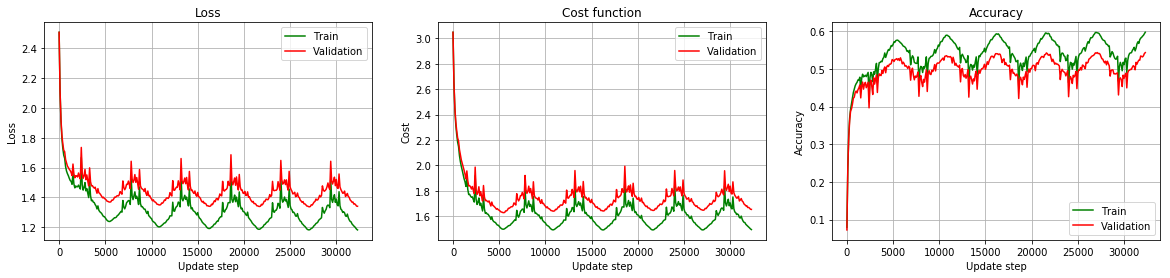

test_accuracy 0.5315


{'test_accuracy': 0.5315, 'val_accuracy': 0.5454}

In [57]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l = -2.039120
params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 50,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': 10**l, 'l': l}
train_model(params, datasets, plot_acc_costs=True)

## Optimising performance 

We will try a higher number of hidden nodes and see if the classification increases. We probably need a higher amount of regularisation with the higher number of nodes

In [202]:
results = []
hidden_nodes = [50, 100, 150, 200]
lamdas = [-2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0]
for h in hidden_nodes:
    for l in lamdas:
        print('number of hidden nodes', h, 'lamda', l)
        batch_size = 100
        number_of_batches = train_X.shape[1] / batch_size 
        n_s = 2*int(number_of_batches)
        no_cycles = 2
        n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

        params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': h,
                  'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': 10**l, 'l': l}
        res = train_model(params, datasets, plot_acc_costs=False)
        results.append({**params, **res})

df_hidden_nodes = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_hidden_nodes[['n_hidden', 'lamda', 'val_accuracy', 'test_accuracy']]
df_hidden_nodes.to_csv('hidden_nodes.csv')

number of hidden nodes 50 lamda -2.5
Cyclical learning rate
test_accuracy 0.5126
number of hidden nodes 50 lamda -2.25
Cyclical learning rate
test_accuracy 0.5176
number of hidden nodes 50 lamda -2.0
Cyclical learning rate
test_accuracy 0.5127
number of hidden nodes 50 lamda -1.75
Cyclical learning rate
test_accuracy 0.5013
number of hidden nodes 50 lamda -1.5
Cyclical learning rate
test_accuracy 0.4878
number of hidden nodes 50 lamda -1.25
Cyclical learning rate
test_accuracy 0.4601
number of hidden nodes 50 lamda -1.0
Cyclical learning rate
test_accuracy 0.4168
number of hidden nodes 100 lamda -2.5
Cyclical learning rate
test_accuracy 0.5274
number of hidden nodes 100 lamda -2.25
Cyclical learning rate
test_accuracy 0.5268
number of hidden nodes 100 lamda -2.0
Cyclical learning rate
test_accuracy 0.5216
number of hidden nodes 100 lamda -1.75
Cyclical learning rate
test_accuracy 0.5148
number of hidden nodes 100 lamda -1.5
Cyclical learning rate
test_accuracy 0.4938
number of hidden n

[0.1, 0.05623413251903491, 0.03162277660168379, 0.01778279410038923, 0.0031622776601683794, 0.01, 0.005623413251903491]
[0.4168, 0.4601, 0.4878, 0.5013, 0.5126, 0.5127, 0.5176]
[0.1, 0.05623413251903491, 0.03162277660168379, 0.01778279410038923, 0.01, 0.005623413251903491, 0.0031622776601683794]
[0.4182, 0.4644, 0.4938, 0.5148, 0.5216, 0.5268, 0.5274]
[0.1, 0.05623413251903491, 0.03162277660168379, 0.01778279410038923, 0.01, 0.0031622776601683794, 0.005623413251903491]
[0.4191, 0.468, 0.4986, 0.524, 0.5345, 0.5353, 0.5354]
[0.1, 0.05623413251903491, 0.03162277660168379, 0.01778279410038923, 0.005623413251903491, 0.01, 0.0031622776601683794]
[0.4193, 0.4669, 0.4982, 0.5241, 0.5371, 0.5391, 0.5413]


Text(0, 0.5, 'Test Accuracy')

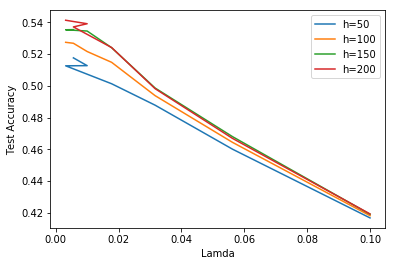

In [206]:
for h in hidden_nodes:
    df = df_hidden_nodes[df_hidden_nodes['n_hidden']==h].sort_values(by=['test_accuracy'], ascending=True)
    y = list(df['test_accuracy'])
    x = list(df['lamda'])
    print(x)
    print(y)
    plt.plot(x, y, label=f'h={h}')
# plt.plot(50, )
plt.xlabel('Lamda')
plt.legend()
plt.ylabel('Test Accuracy')  

In [210]:
df_hidden_nodes.sort_values(by=['test_accuracy'], ascending=False)

,batch_size,eta_max,eta_min,l,lamda,n_epochs,n_hidden,n_s,test_accuracy,val_accuracy
21,100,0.1,0.00001,-2.50,0.003162,8,200,900,0.5413,0.5538
23,100,0.1,0.00001,-2.00,0.010000,8,200,900,0.5391,0.5496
22,100,0.1,0.00001,-2.25,0.005623,8,200,900,0.5371,0.5506
15,100,0.1,0.00001,-2.25,0.005623,8,150,900,0.5354,0.5444
14,100,0.1,0.00001,-2.50,0.003162,8,150,900,0.5353,0.5536
16,100,0.1,0.00001,-2.00,0.010000,8,150,900,0.5345,0.5402
7,100,0.1,0.00001,-2.50,0.003162,8,100,900,0.5274,0.5444
8,100,0.1,0.00001,-2.25,0.005623,8,100,900,0.5268,0.5392
24,100,0.1,0.00001,-1.75,0.017783,8,200,900,0.5241,0.5252
17,100,0.1,0.00001,-1.75,0.017783,8,150,900,0.5240,0.5278


Apply dropout - does dropout overcompensate for no regularisation?

In [180]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 2*int(number_of_batches)
no_cycles = 2
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)
lamdas = [0, 0.0025, 0.005, 0.0075, 0.01]
dropout_threshes = [0, 0.2, 0.4]

results = []
for lamda in lamdas:
    for dropout in dropout_threshes:
        print('lamda', lamda, 'dropout thresh', 1-dropout_p)
        params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 200,
                  'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': lamda, 'dropout_thresh': dropout}  
        res = train_model(params, datasets, plot_acc_costs=False)
        results.append({**params, **res})

lamda 0 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5377
lamda 0 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5459
lamda 0 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5416
lamda 0.0025 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5418
lamda 0.0025 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5392
lamda 0.0025 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5427
lamda 0.005 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5423
lamda 0.005 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5399
lamda 0.005 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5461
lamda 0.0075 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5411
lamda 0.0075 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5404
lamda 0.0075 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5398
lamda 0.01 dropout thresh 1
Cyclical learning rate
test_accuracy 0.5386
lamda 0.01 dropout thresh 1
Cyclical learning rate
test_ac

In [181]:
df_dropout = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
print(df_dropout[['dropout_thresh', 'lamda', 'val_accuracy', 'test_accuracy']])
df_dropout.to_csv('dropout.csv')

    dropout_thresh   lamda  val_accuracy  test_accuracy
8              0.4  0.0050        0.5508         0.5461
1              0.2  0.0000        0.5538         0.5459
5              0.4  0.0025        0.5540         0.5427
6              0.0  0.0050        0.5548         0.5423
3              0.0  0.0025        0.5506         0.5418
2              0.4  0.0000        0.5408         0.5416
9              0.0  0.0075        0.5512         0.5411
10             0.2  0.0075        0.5506         0.5404
7              0.2  0.0050        0.5500         0.5399
11             0.4  0.0075        0.5476         0.5398
4              0.2  0.0025        0.5512         0.5392
12             0.0  0.0100        0.5430         0.5386
0              0.0  0.0000        0.5594         0.5377
14             0.4  0.0100        0.5442         0.5375
13             0.2  0.0100        0.5448         0.5363


[0.0, 0.0025, 0.005, 0.0075]
[0.5377, 0.5418, 0.5423, 0.5411]
[0.0, 0.0025, 0.005, 0.0075]
[0.5459, 0.5392, 0.5399, 0.5404]
[0.0, 0.0025, 0.005, 0.0075]
[0.5416, 0.5427, 0.5461, 0.5398]


Text(0, 0.5, 'Test Accuracy')

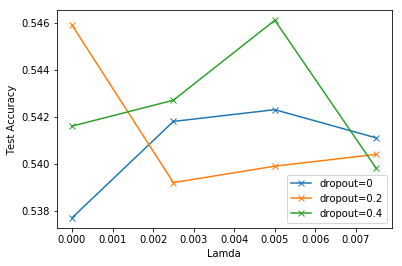

In [182]:
for dropout in dropout_threshes:
    df = df_dropout[df_dropout['dropout_thresh']==dropout].sort_values(by=['lamda'], ascending=True)
    y = list(df['test_accuracy'])[:-1]
    x = list(df['lamda'])[:-1]
    print(x)
    print(y)
    plt.plot(x, y, marker='x', label=f'dropout={dropout}')
plt.xlabel('Lamda')
plt.legend()
plt.ylabel('Test Accuracy')            

At the end of each cycle of training we should be in the vicinity of a local minimum. Research in this area seems to indicate that with the cyclical learning rate method the local minima found at the end of each cycle are different. Let's build an ensemble of classifiers by saving the network parameter values at the end of each cycle and then taking majority vote classification. We stick to 50 nodes for comparison against the base model.

In [5]:
def train_ensemble(self, X, Y, random_shuffle=False):
        n = X.shape[1]
        
        number_of_batches = int(n / self.batch_size)
        assert number_of_batches > 0
        indices = np.arange(X.shape[1])
        if random_shuffle:
            print('Randomly shuffling')
        
        if self.cyclical_lr:
            print('Cyclical learning rate')
        
        t = 0 # each update step % 2*n_s
        ensemble_params = []
        
        for epoch in range(self.n_epochs):     
            if random_shuffle:
                np.random.shuffle(indices)
                X = np.take(X, indices, axis=1)
                Y = np.take(Y, indices, axis=1)
                
            for j in range(number_of_batches):
                eta = self.compute_cyclical_lr(t)
                
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
    
                # Perform MiniBatch Gradient Descent
                grad_W1, grad_W2, grad_b1, grad_b2 = self.compute_gradients(Xbatch, Ybatch, self.W1, self.W2, self.b1, self.b2)
                self.W1 -= eta * grad_W1
                self.W2 -= eta * grad_W2
                self.b1 -= eta *  grad_b1
                self.b2 -= eta *  grad_b2
                    
                if t > 0 and (t % (self.n_s * 2) == 0):
                    # save parameters
                    ensemble_params.append([self.W1, self.W2, self.b1, self.b2])
                    
                t += 1
        # add last one at end of last cycle
        ensemble_params.append([self.W1, self.W2, self.b1, self.b2])
       
        np.save('ensemble_model_params.npy', ensemble_params)
        
        
def max_vote(pred):
    return np.bincount(pred).argmax()
    
    
def test_ensemble(self, X, Y):
    ''' X is data (dim, N), y is gt (C, N)'''
    model_params = np.load('ensemble_model_params.npy', allow_pickle=True) 
    ensemble_predictions = []
    for params in model_params:
        W1, W2, b1, b2 = params
        _, P = self.forward_pass(X, W1, W2, b1, b2)
        ensemble_predictions.append(np.argmax(P, axis=0))
    ensemble_predictions = np.asarray(ensemble_predictions)
    # take max vote
    N = X.shape[1]
    pred = [max_vote(ensemble_predictions[:,i]) for i in range(N)]
    
    lbls = np.argmax(Y, axis=0)
    accuracy = np.mean(pred == lbls)
    return pred, accuracy
    

In [58]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)
lamda = 10**-2.039120 # taken as optimal from previous part of assignment
clf = TwoLayerClassifer(input_dim=train_X.shape[0], n_hidden=50, batch_size=batch_size, n_epochs=n_epochs, lamda=lamda, cyclical_lr=True, n_s=n_s, eta_min=10**-5, eta_max=0.1)
train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
train_ensemble(clf, train_X, train_Y)
_, accuracy = test_ensemble(clf, test_X, test_Y)
print('Test accuracy using majority vote ensemble', accuracy)

Cyclical learning rate
Test accuracy using majority vote ensemble 0.5248


Cyclical learning rate


/Users/amritapanesar/KTH-Courses/Artificial-Neural-Networks/venv-anns/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


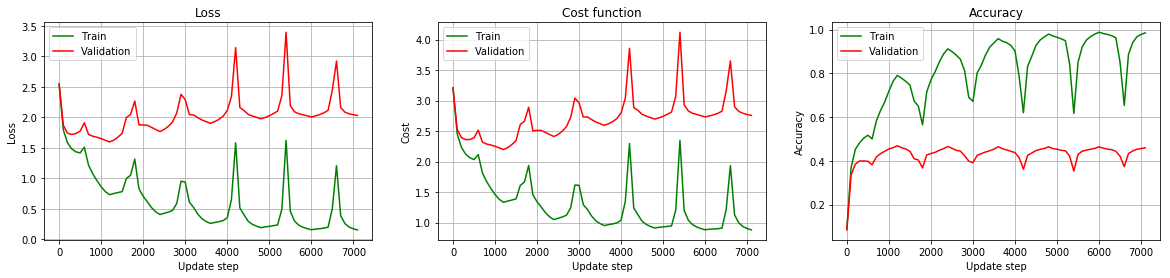

test_accuracy 0.4597


{'test_accuracy': 0.4597, 'val_accuracy': 0.4647}

In [7]:
# what about with the higher number of nodes found from (b)
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l = -2.039120
params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 200,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': n_s, 'lamda': 0.0031622776601683794}
train_model(params, datasets, plot_acc_costs=True)

## Set eta_min and eta_max according to [Smith, 2015] 

Smith, L. N. (2015). Cyclical learning rates for training neural networks. arXiv:1506.01186 [cs.CV]. We perform the LR test, increasing the learning rate linearly over the iterations from 0 to 0.02. 

In [5]:
# we use full training set 

def find_eta_range(params, datasets):
    train_X, train_Y, val_X, val_Y, test_X , test_Y = datasets
    n_classes = 10
    input_dim = train_X.shape[0]
    number_of_batches = int(train_X.shape[1] / params['batch_size'])
    clf = TwoLayerClassifer(input_dim, n_hidden=params['n_hidden'], batch_size=params['batch_size'], n_epochs=params['n_epochs'], lamda=params['lamda'], lr_range_test=True)

    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
    accuracies, _, _, etas = clf.train(train_X, train_Y, get_accuracies_costs=False, 
                                      val_X = val_X, val_Y = val_Y, max_lr=params['max_lr'])
    
    plt.plot(etas, accuracies['val'], 'r', label='val')
    plt.plot(etas, accuracies['train'], 'g', label='train')
    plt.title('Accuracy')
    plt.xlabel('Eta')
    plt.ylabel('Accuracy')
    plt.legend()

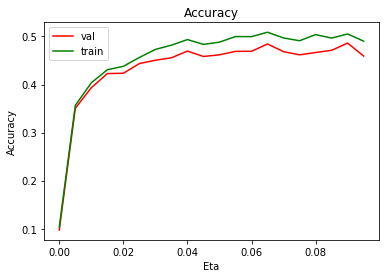

In [21]:
params = {'lamda': 10**-2.039120, 'batch_size': 100, 'n_hidden': 50, 'n_epochs': 8, 'max_lr': 0.1}
find_eta_range(params, datasets)

We note that the accuracy starts to increase from 0 and decreases in a ragged format from 0.045.

Cyclical learning rate


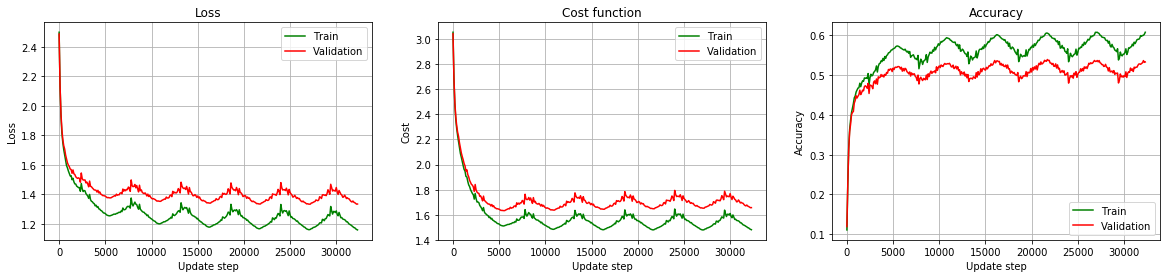

test_accuracy 0.5265


{'test_accuracy': 0.5265, 'val_accuracy': 0.5344}

In [27]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l = -2.039120
params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 50,
          'eta_min': 0, 'eta_max': 0.06, 'n_s': n_s, 'lamda': 10**l, 'l': l}
train_model(params, datasets, plot_acc_costs=True)

In [ ]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

l = -2.039120
params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 50,
          'eta_min': 0.0000005, 'eta_max': 0.06, 'n_s': n_s, 'lamda': 10**l, 'l': l}
train_model(params, datasets, plot_acc_costs=True)

What about with 200 hidden nodes?

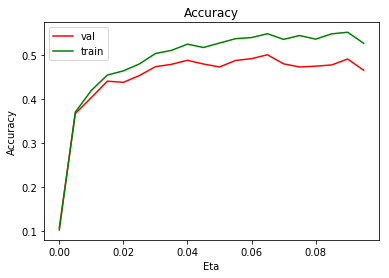

In [11]:
params = {'lamda': 0.003162, 'batch_size': 100, 'n_hidden': 200, 'n_epochs': 8, 'max_lr': 0.1}
find_eta_range(params, datasets)

Cyclical learning rate


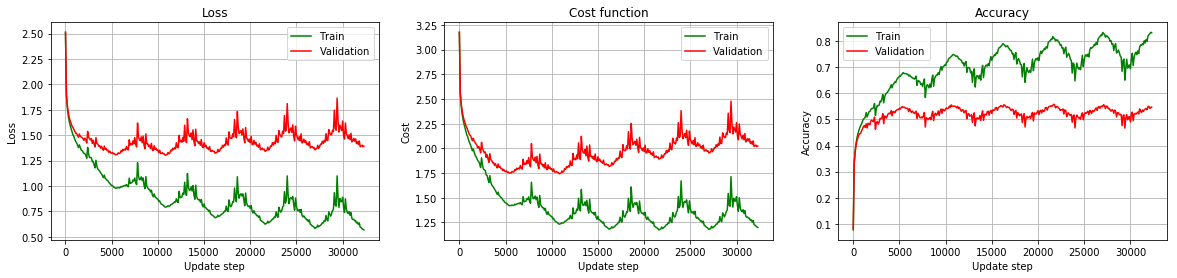

test_accuracy 0.5363


{'test_accuracy': 0.5363, 'val_accuracy': 0.549}

In [12]:
batch_size = 100
number_of_batches = train_X.shape[1] / batch_size 
n_s = 6*int(number_of_batches)
no_cycles = 6
n_epochs = int(n_s * 2 * no_cycles / number_of_batches)

params = {'n_epochs':  n_epochs, 'batch_size': batch_size, 'n_hidden': 200,
          'eta_min': 0.005, 'eta_max': 0.05, 'n_s': n_s, 'lamda': 0.003162}
train_model(params, datasets, plot_acc_costs=True)